In [1]:
import pydicom
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import math
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, VBox, HBox, Output
from scipy.ndimage import map_coordinates
from scipy.ndimage import convolve as scipy_convolve 
import nibabel as nib 
import matplotlib.colors as mcolors

# Actividad 1: Manipulación de imágenes, DICOM y color

**Nombre:** Maximiliano Antonio Gaete Pizarro

**RUT:** 21.320.154-9

In [2]:
data_dir_1 = './Tarea_1/datos/data_1'
output_csv_data_1 = 'patient_info_data1.csv'
output_data_1_anon = './Tarea_1/datos/data_1_anon'

data_dir_2 = './Tarea_1/datos/data_2'

p5_filepath = './Tarea_1/datos/p5.dcm'
xray_filepath = './Tarea_1/datos/xray.dcm'

anat_filepath = './Tarea_1/datos/anat.nii'
zmap_voice_filepath = './Tarea_1/datos/zmap_voice.nii'
zmap_nonvoice_filepath = './Tarea_1/datos/zmap_nonvoice.nii'

### 3.1 Extracción de Información de Pacientes (data_1)

los archivos DICOM del directorio `data_1`. De cada archivo, extraemos el nombre del paciente y su fecha de nacimiento. Luego, guardamos esta información en un archivo CSV para tenerla ordenada.

In [3]:
patient_data = []

for filename in os.listdir(data_dir_1):

    filepath = os.path.join(data_dir_1, filename)

    if os.path.isfile(filepath):
        ds = pydicom.dcmread(filepath, force=True)

        patient_name = ds.get('PatientName', 'N/A') # Nombre
        birth_date = ds.get('PatientBirthDate', 'N/A') # Cumpleaños

        # Añadir los datos a una lista
        patient_data.append([patient_name, birth_date])
        print(f"Nombre: {patient_name}, Cumpleaños: {birth_date}")

total_pacientes = len(patient_data)
print(f"Total de pacientes procesados: {total_pacientes}")

if patient_data: # Solo escribir si se encontraron datos
    with open(output_csv_data_1, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        # Escribir la cabecera
        writer.writerow(['PatientName', 'PatientBirthDate'])
        # Escribir los datos de los pacientes
        writer.writerows(patient_data)
        print(f"Datos escritos en {output_csv_data_1}")

Nombre: Débora Salas, Cumpleaños: 19770508
Nombre: Luis Chabert, Cumpleaños: 19830208
Nombre: Alejandro Chabert, Cumpleaños: 19791001
Nombre: Cesar Buendía, Cumpleaños: 19830729
Nombre: Germán Roncagliolo, Cumpleaños: 19770513
Nombre: Pablo Roncagliolo, Cumpleaños: 19830202
Nombre: Germán Salas, Cumpleaños: 19850204
Nombre: Pablo Buendía, Cumpleaños: 19850915
Nombre: Wael Veloz, Cumpleaños: 19770720
Nombre: Germán Buendía, Cumpleaños: 19830404
Nombre: Wael Veloz, Cumpleaños: 19850114
Nombre: Wael Weinstein, Cumpleaños: 19790504
Nombre: Wael Salas, Cumpleaños: 19751019
Nombre: Steren Veloz, Cumpleaños: 19851117
Nombre: Scarlett Salas, Cumpleaños: 19790118
Nombre: Germán Weinstein, Cumpleaños: 19771120
Nombre: Luis Veloz, Cumpleaños: 19790923
Nombre: Débora Chabert, Cumpleaños: 19810913
Nombre: Germán Lever, Cumpleaños: 19850103
Nombre: Germán Buendía, Cumpleaños: 19850401
Total de pacientes procesados: 20
Datos escritos en patient_info_data1.csv


## 3.2

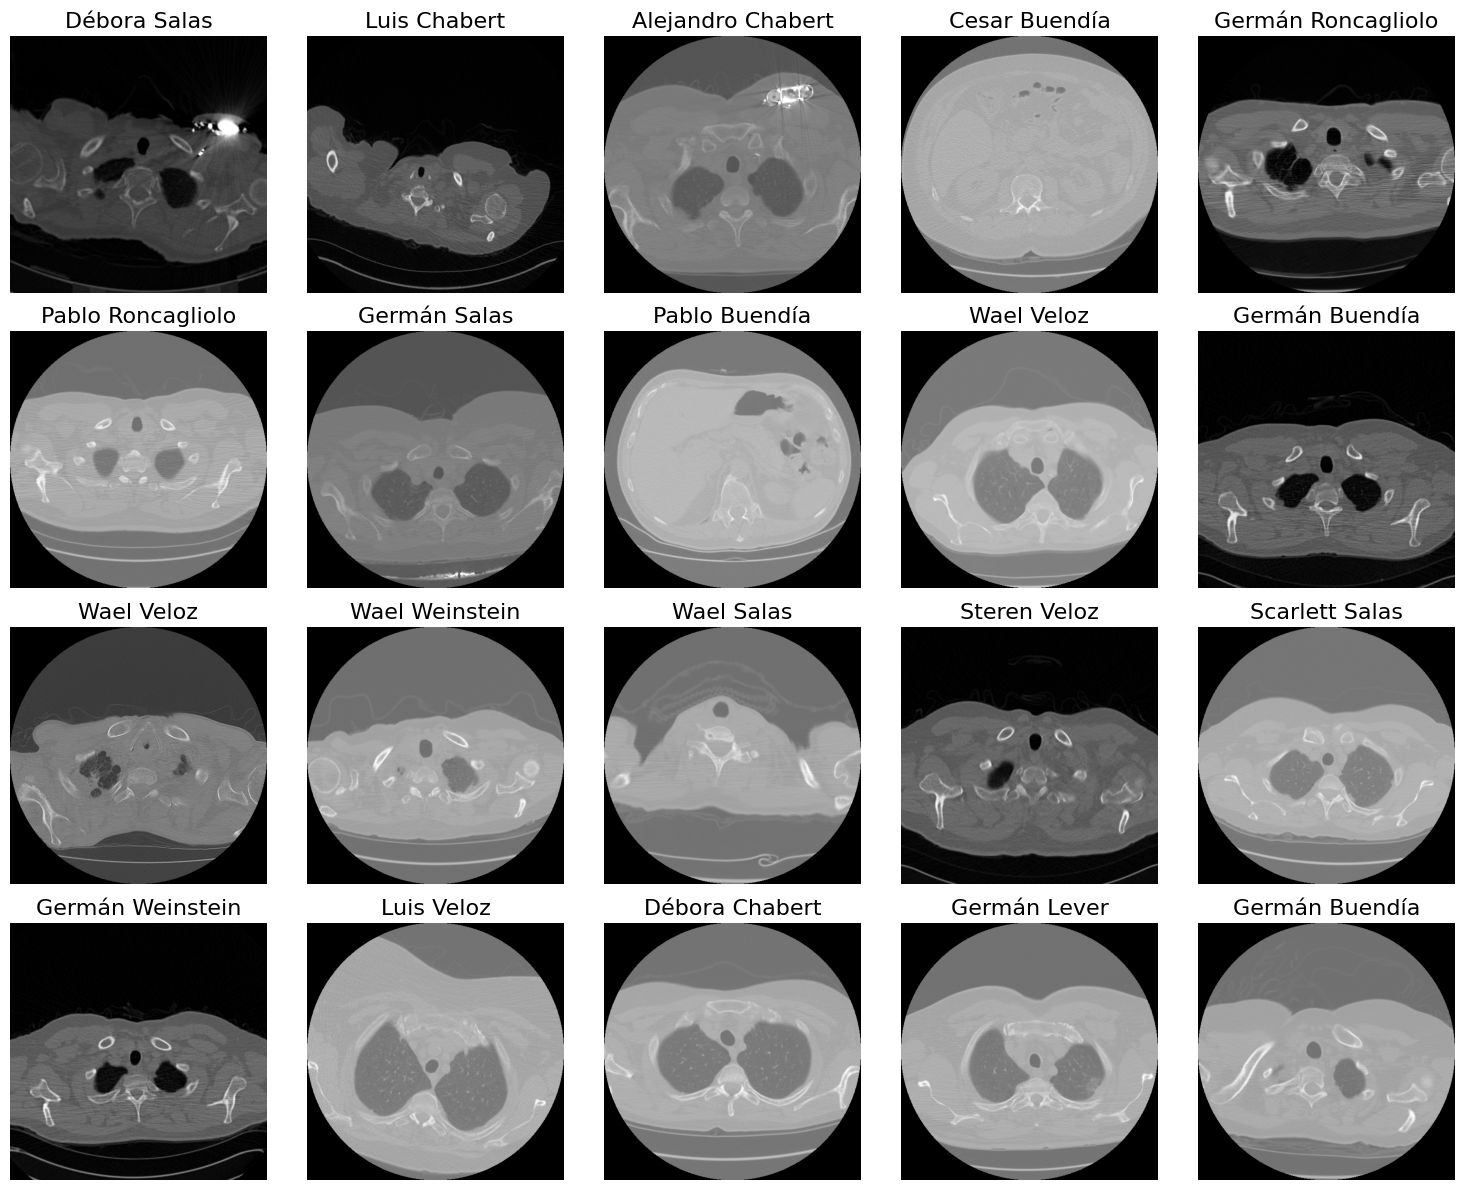

In [4]:

dicom_files = []

for filename in os.listdir(data_dir_1):

    filepath = os.path.join(data_dir_1, filename)

    if os.path.isfile(filepath):

        dicom_files.append(filepath)

# leer
valid_datasets = []
patient_names = []

for filepath in dicom_files:

    ds = pydicom.dcmread(filepath) # lee pixeles


    if 'PixelData' in ds:

        patient_name_tag = ds.get('PatientName', 'Nombre Desconocido')
        if isinstance(patient_name_tag, pydicom.valuerep.PersonName):
            patient_name = str(patient_name_tag)

        valid_datasets.append(ds)
        patient_names.append(patient_name)


if valid_datasets:

    # dimensiones
    num_images = len(valid_datasets)

    cols = math.ceil(math.sqrt(num_images))
    rows = math.ceil(num_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3)) # Ajusta el tamaño por subplot

    axes = axes.ravel()

    # Iterar sobre los datasets DICOM válidos y mostrarlos
    for i, ds in enumerate(valid_datasets):

        axes[i].imshow(ds.pixel_array, cmap=plt.cm.gray)
        # nombre del paciente
        axes[i].set_title(patient_names[i], fontsize=16)
        axes[i].axis('off')

    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

### 3.3 Anonimización de Datos (data_1_anon)

Para proteger la privacidad de los pacientes, es importante anonimizar los datos antes de compartirlos o usarlos en investigaciones.

In [5]:
# directorio de salida 
if not os.path.exists(output_data_1_anon):
    os.makedirs(output_data_1_anon)
    print(f"Directorio '{output_data_1_anon}' creado.")

# Campos DICOM comunes que suelen contener información personal
tags_to_anonymize = [
    "PatientName",
    "PatientID",
    "PatientBirthDate",
    "PatientSex",
    "PatientAge",
    "PatientAddress",
    "PatientTelephoneNumbers",
]


for filename in os.listdir(data_dir_1):
    filepath = os.path.join(data_dir_1, filename)
    
    if os.path.isfile(filepath) and filename.lower().endswith('.dcm'):
        # Leemos el archivo DICOM
        ds = pydicom.dcmread(filepath)
        
        # Iteramos sobre las etiquetas 
        for tag_name in tags_to_anonymize:
            if tag_name in ds:

                tag_element = ds.data_element(tag_name)
                if tag_element: 
                    tag_element.value = "" # reemplazar por vacío
        
        ds.SOPInstanceUID = pydicom.uid.generate_uid()

        #  ruta de salida
        output_filepath = os.path.join(output_data_1_anon, filename)
        
        ds.save_as(output_filepath)
        print(f"Archivo DICOM anonimizado guardado como: {output_filepath}")

        # Imprimir cómo se ve cada dato anonimizado
        for filename in os.listdir(output_data_1_anon):
            filepath = os.path.join(output_data_1_anon, filename)
            if os.path.isfile(filepath) and filename.lower().endswith('.dcm'):
                ds = pydicom.dcmread(filepath)
                print(f"Archivo: {filename}")
                for tag_name in tags_to_anonymize:
                    if tag_name in ds:
                        print(f"  {tag_name}: {ds.get(tag_name, 'N/A')}")
                print(f"  SOPInstanceUID: {ds.SOPInstanceUID}")
                print("-" * 40)


Archivo DICOM anonimizado guardado como: ./Tarea_1/datos/data_1_anon\019787df3ae203ec160fb86dbee9275b.dcm
Archivo: 019787df3ae203ec160fb86dbee9275b.dcm
  PatientName: 
  PatientID: 
  PatientBirthDate: 
  SOPInstanceUID: 1.2.826.0.1.3680043.8.498.57384633080866818106906758418388609668
----------------------------------------
Archivo: 121969a3ea1dcd63ea14b7c8754098d3.dcm
  PatientName: 
  PatientID: 
  PatientBirthDate: 
  SOPInstanceUID: 1.2.826.0.1.3680043.8.498.30408826722173906828460281655853699549
----------------------------------------
Archivo: 16e2678d2ea8d8638f69a6f7b54eb030.dcm
  PatientName: 
  PatientID: 
  PatientBirthDate: 
  SOPInstanceUID: 1.2.826.0.1.3680043.8.498.18985747198127297123413278442309822124
----------------------------------------
Archivo: 22b3866a120110dde0ed9bfd73088e93.dcm
  PatientName: 
  PatientID: 
  PatientBirthDate: 
  SOPInstanceUID: 1.2.826.0.1.3680043.8.498.29820677221108064844607885039411982813
----------------------------------------
Archivo: 2

### 3.4 Carga y Visualización Interactiva de Volumen 3D (data_2)

Ahora trabajamos con el conjunto de datos `data_2`. Estos archivos DICOM representan cortes axiales que forman un volumen 3D. Los cargamos, ordenamos y los apilamos para formar una matriz 3D con NumPy.

Para entender mejor la anatomía, visualizamos este volumen desde diferentes perspectivas usando `matplotlib` y `ipywidgets`.

In [6]:
dicom_datasets = []

for filename in os.listdir(data_dir_2):
    filepath = os.path.join(data_dir_2, filename)
    if os.path.isfile(filepath) and filename.lower().endswith('.dcm'):
        try:
            ds = pydicom.dcmread(filepath)
            dicom_datasets.append(ds)
        except Exception as e:
            print(f"Error al leer {filename}: {e}")



# ordenamos los datasets por InstanceNumber
dicom_datasets.sort(key=lambda x: int(x.InstanceNumber))
print("Cortes ordenados por InstanceNumber.")


if dicom_datasets:
    # Apilamos los datos de píxeles para formar el volumen 3D
    volume_3d = np.stack([ds.pixel_array for ds in dicom_datasets]).astype(np.float64) # Usar float
    depth, height, width = volume_3d.shape # Z, Y, X
    print(f"Volumen 3D creado con dimensiones (Z={depth}, Y={height}, X={width})")

    # Calculamos espaciado y aspect ratios 
    try:
        pixel_spacing = dicom_datasets[0].PixelSpacing # [espacio_Y, espacio_X]
        # Calcular grosor de corte 
        if len(dicom_datasets) > 1 and 'SliceLocation' in dicom_datasets[0] and 'SliceLocation' in dicom_datasets[1]:
                slice_thickness = abs(float(dicom_datasets[1].SliceLocation) - float(dicom_datasets[0].SliceLocation))
                print(f"Slice thickness calculado por diferencia SliceLocation: {slice_thickness:.2f} mm")
        else:
                # Si no, usar SliceThickness si existe, si no, asumir 1
                slice_thickness = float(dicom_datasets[0].get('SliceThickness', 1.0))
                print(f"Slice thickness obtenido de etiqueta o asumido: {slice_thickness:.2f} mm")

    except (AttributeError, TypeError, ValueError) as e_spacing:
        print(f"Advertencia: No se pudo obtener PixelSpacing/SliceThickness ({e_spacing}).")
        print("Usando aspect ratio 1.0 para las vistas.")
        pixel_spacing = [1.0, 1.0]
        slice_thickness = 1.0

    # Aspect = espacio_horizontal_en_plot / espacio_vertical_en_plot
    aspect_axial = pixel_spacing[1] / pixel_spacing[0]     # Eje X / Eje Y
    aspect_coronal = pixel_spacing[1] / slice_thickness   # Eje X / Eje Z
    aspect_sagittal = pixel_spacing[0] / slice_thickness  # Eje Y / Eje Z

    print(f"Aspect ratios -> Axial: {aspect_axial:.2f}, Coronal: {aspect_coronal:.2f}, Sagittal: {aspect_sagittal:.2f}")

    def mostrar_vistas_interactivas(posicion_x, posicion_y, posicion_z):
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # Ajusta tamaño como necesites
        fig.suptitle(f'Visor Multiplanar Interactivo (X={posicion_x}, Y={posicion_y}, Z={posicion_z})')

        # 1. Vista Axial (Plano XY en Z fijo)
        corte_axial = volume_3d[posicion_z, :, :]
        axes[0].imshow(corte_axial, cmap='gray', aspect=aspect_axial)
        axes[0].set_title(f'Axial (Z = {posicion_z})')
        axes[0].set_xlabel("Eje X")
        axes[0].set_ylabel("Eje Y")
        axes[0].axhline(posicion_y, color='lime', linewidth=1, alpha=0.7) # Línea para corte Coronal (Y)
        axes[0].axvline(posicion_x, color='dodgerblue', linewidth=1, alpha=0.7) # Línea para corte Sagital (X)

        # 2. Vista Coronal (Plano XZ en Y fijo)
        corte_coronal = volume_3d[:, posicion_y, :]
        axes[1].imshow(corte_coronal.T, cmap='gray', aspect=aspect_coronal)
        axes[1].set_title(f'Coronal (Y = {posicion_y})')
        axes[1].set_xlabel("Eje X")
        axes[1].set_ylabel("Eje Z (Profundidad)")
        axes[1].axhline(posicion_z, color='red', linewidth=1, alpha=0.7) # Línea para corte Axial (Z)
        axes[1].axvline(posicion_x, color='dodgerblue', linewidth=1, alpha=0.7) # Línea para corte Sagital (X)

        # 3. Vista Sagital (Plano YZ en X fijo)
        corte_sagital = volume_3d[:, :, posicion_x]
        axes[2].imshow(corte_sagital.T, cmap='gray', aspect=aspect_sagittal)
        axes[2].set_title(f'Sagital (X = {posicion_x})')
        axes[2].set_xlabel("Eje Y")
        axes[2].set_ylabel("Eje Z (Profundidad)")
        axes[2].axhline(posicion_z, color='red', linewidth=1, alpha=0.7) # Línea para corte Axial (Z)
        axes[2].axvline(posicion_y, color='lime', linewidth=1, alpha=0.7) # Línea para corte Coronal (Y)

        plt.tight_layout(rect=[0, 0.03, 1, 0.93]) 
        plt.show()

    print("\n--- Visor Multiplanar Interactivo ---")
    print("Mueve los sliders para explorar las 3 vistas simultáneamente:")

    interact(mostrar_vistas_interactivas,
                posicion_x=IntSlider(min=0, max=width-1, step=1, value=width//2, description='Corte X (Sag):', continuous_update=True), # Update continuo para fluidez
                posicion_y=IntSlider(min=0, max=height-1, step=1, value=height//2, description='Corte Y (Cor):', continuous_update=True),
                posicion_z=IntSlider(min=0, max=depth-1, step=1, value=depth//2, description='Corte Z (Axi):', continuous_update=True)
            )



Cortes ordenados por InstanceNumber.
Volumen 3D creado con dimensiones (Z=110, Y=512, X=512)
Slice thickness calculado por diferencia SliceLocation: 2.50 mm
Aspect ratios -> Axial: 1.00, Coronal: 0.25, Sagittal: 0.25

--- Visor Multiplanar Interactivo ---
Mueve los sliders para explorar las 3 vistas simultáneamente:


interactive(children=(IntSlider(value=256, description='Corte X (Sag):', max=511), IntSlider(value=256, descri…

### 3.5 Corte Oblicuo 

Además de los cortes estándar, podemos generar cortes en ángulos arbitrarios (oblicuos). Definimos una función que, dado un ángulo de rotación alrededor del eje Z y un desplazamiento, calcula las coordenadas del plano oblicuo e interpola los valores de los píxeles del volumen 3D original usando `scipy.ndimage.map_coordinates`. Usamos `ipywidgets` para controlar interactivamente el ángulo y el desplazamiento.

In [7]:
if 'volume_3d' not in locals():
     print("El 'volume_3d' no fue cargado o creado en el paso anterior.")
else:
    print("\n--- Visualizador Interactivo de Corte Oblicuo ---")

    def ver_corte_oblicuo(angulo_grados, offset_plano):
        """
        Calcula un corte oblicuo que rota alrededor del eje Z.
        Un ángulo de 0 grados es similar a un Coronal.
        Un ángulo de 90 grados es similar a un Sagital.
        Offset desplaza el plano desde el centro.
        """
        try:
            # el ángulo a radianes
            angulo_rad = np.deg2rad(angulo_grados)
            
            # Centro de la imagen (alrededor del cual rotamos el plano XY)
            centro_x, centro_y = width // 2, height // 2
    
            # Tendrá la altura Z del volumen original y una anchura 'S' que recorre el plano XY inclinado.
            max_s = int(np.sqrt(width**2 + height**2) / 1.5) 
            coords_z, coords_s = np.mgrid[0:depth, -max_s//2 : max_s//2]
    

            x_vol = coords_s * np.cos(angulo_rad) + centro_x + offset_plano * np.sin(angulo_rad)
            y_vol = -coords_s * np.sin(angulo_rad) + centro_y + offset_plano * np.cos(angulo_rad) 
            # El Z es directo: z_vol = coords_z
    
            # Apilamos las coordenadas en el orden que espera map_coordinates: [Z, Y, X]
            coords_vol = np.stack([coords_z.ravel(), y_vol.ravel(), x_vol.ravel()])
    

            corte_oblicuo_flat = map_coordinates(volume_3d, coords_vol, order=1, mode='nearest')
            
            corte_oblicuo = corte_oblicuo_flat.reshape(coords_z.shape)
    
            # Visualizamos el corte oblicuo
            plt.figure(figsize=(8, 8))
            plt.imshow(corte_oblicuo.T, cmap='gray', aspect=0.25) # Transponemos para Z vertical
            plt.title(f'Corte Oblicuo (Ángulo = {angulo_grados}°, Offset = {offset_plano})')
            plt.xlabel("Eje S (en plano XY rotado)")
            plt.ylabel("Eje Z (Profundidad)")
            plt.gca().invert_yaxis() # Orientación estándar Z
            plt.show()

        except NameError as ne:
             print(f"Error: Parece que falta una variable necesaria (ej. volume_3d). ¿Ejecutaste la celda anterior? Detalle: {ne}")
        except Exception as e:
             print(f"Ocurrió un error al generar el corte oblicuo: {e}")

    offset_max = max(width, height) // 3
    
    interact(ver_corte_oblicuo,
             angulo_grados=FloatSlider(min=0, max=180, step=5, value=45, description='Ángulo (°):'),
             offset_plano=IntSlider(min=-offset_max, max=offset_max, step=5, value=0, description='Offset:'))



--- Visualizador Interactivo de Corte Oblicuo ---


interactive(children=(FloatSlider(value=45.0, description='Ángulo (°):', max=180.0, step=5.0), IntSlider(value…

### 3.6 Downsampling (Submuestreo)

El submuestreo es una técnica útil para reducir el tamaño de las imágenes, aunque puede implicar pérdida de detalle. Aquí cargamos la imagen `p5.dcm` y creamos una versión reducida tomando uno de cada cuatro píxeles en ambas direcciones (horizontal y vertical). Comparamos visualmente la imagen original con la submuestreada.

Imagen p5.dcm cargada. Dimensiones originales: (512, 512)
Dimensiones después de downsampling (1 de cada 4): (128, 128)


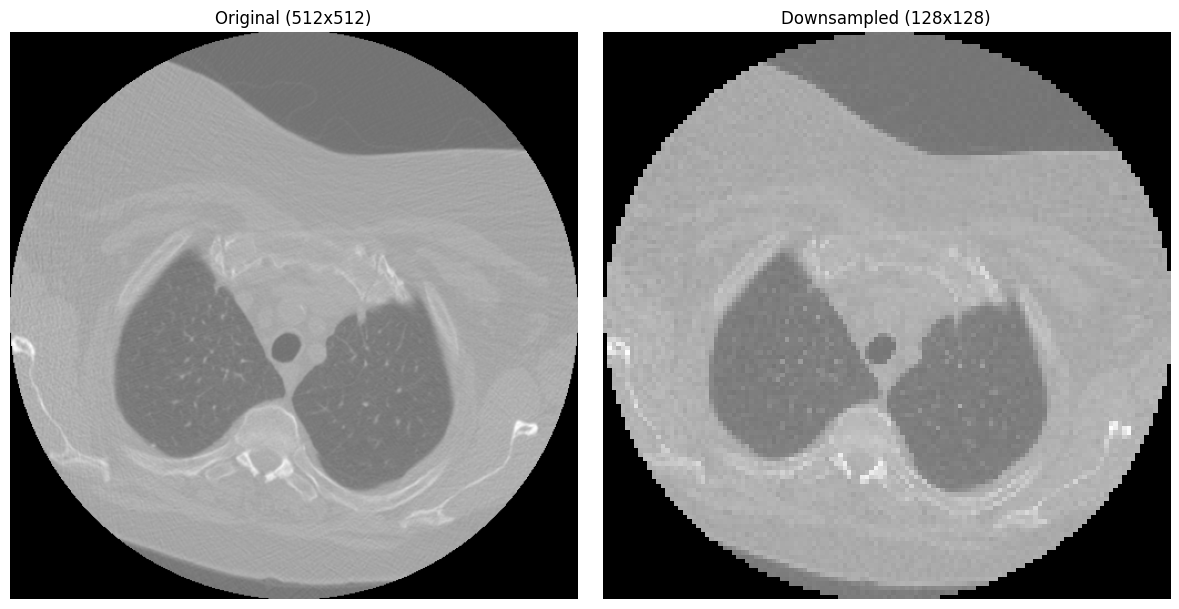

In [8]:


ds_p5 = pydicom.dcmread(p5_filepath)
img_p5_original = ds_p5.pixel_array
print(f"Imagen p5.dcm cargada. Dimensiones originales: {img_p5_original.shape}")

img_p5_downsampled = img_p5_original[::4, ::4]
print(f"Dimensiones después de downsampling (1 de cada 4): {img_p5_downsampled.shape}")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Imagen Original
axes[0].imshow(img_p5_original, cmap='gray')
axes[0].set_title(f'Original ({img_p5_original.shape[0]}x{img_p5_original.shape[1]})')
axes[0].axis('off') 

# Imagen Reducida
axes[1].imshow(img_p5_downsampled, cmap='gray')
axes[1].set_title(f'Downsampled ({img_p5_downsampled.shape[0]}x{img_p5_downsampled.shape[1]})')
axes[1].axis('off')

plt.tight_layout() 
plt.show()


La imagen **original (512x512)** es de alta resolución, mostrando detalles finos, bordes nítidos y texturas claras de la tomografía pulmonar.

La imagen **submuestreada (downsampled a 128x128)**, al conservar solo uno de cada cuatro píxeles en cada dimensión, tiene una resolución mucho menor. Esto resulta en:

* **Pérdida significativa de detalles:** Las estructuras pequeñas y las texturas finas desaparecen.
* **Bordes pixelados y menos definidos:** Los contornos se ven escalonados o "en bloque".
* **Aspecto general más "borroso" o "grueso"** debido a la menor cantidad de información.

En esencia, el downsampling reduce el tamaño de la imagen a costa de una notable pérdida de calidad visual y detalle informativo.

### 3.7 Mejora de Contraste Interactivo

Para mejorar la visualización de detalles en las imágenes DICOM, aplicamos dos técnicas comunes de mejora de contraste a un corte axial seleccionado: la transformación Gamma (ley de potencia) y la transformación lineal por tramos (estiramiento de contraste). Creamos controles interactivos para ajustar los parámetros (gamma, r1, s1, r2, s2) y ver el efecto en la imagen y su histograma en tiempo real.

In [9]:
if 'volume_3d' not in locals() or 'depth' not in locals() or 'aspect_axial' not in locals():
     print("Falta 'volume_3d' u otra variable de los pasos anteriores")
else:

    def transformacion_gamma(imagen, gamma, c=1.0):
        """Aplica la transformación s = c * r^gamma"""

        img_float = imagen.astype(np.float64)
        min_val, max_val = np.min(img_float), np.max(img_float)
        rango = max_val - min_val
        
        if rango == 0:
            return imagen
            
        # la imagen al rango [0, 1]
        img_norm = (img_float - min_val) / rango
        
        # Aplicamos la ley de potencia
        img_gamma_norm = c * np.power(img_norm, gamma)
        
        img_transformada = (img_gamma_norm * rango) + min_val

        return img_transformada.astype(imagen.dtype)

    def transformacion_lineal_tramos(imagen, r1, s1, r2, s2):
        """Aplica una transformación lineal por tramos definida por (r1,s1) y (r2,s2)."""
        img_float = imagen.astype(np.float64)
        min_val, max_val = np.min(img_float), np.max(img_float)

        # Validamos que los puntos tengan sentido (r1 < r2)
        if r1 >= r2 or max_val == min_val:
            print(f"Advertencia: r1 ({r1}) debe ser menor que r2 ({r2}). No se aplica transformación.")
            return imagen

        # Creamos una imagen de salida vacía
        img_transformada = np.zeros_like(img_float)

        # Pendiente 1 (0 a r1 -> 0 a s1)
        m1 = s1 / r1 if r1 > 0 else 0
        # Pendiente 2 (r1 a r2 -> s1 a s2)
        m2 = (s2 - s1) / (r2 - r1)
        # Pendiente 3 (r2 a max_val -> s2 a max_val - asumimos que el máximo mapea al máximo)
        s_max = max_val
        m3 = (s_max - s2) / (max_val - r2) if max_val > r2 else 0

        # Tramo 1
        mask1 = img_float < r1
        img_transformada[mask1] = m1 * img_float[mask1]
        # Tramo 2
        mask2 = (img_float >= r1) & (img_float <= r2)
        img_transformada[mask2] = m2 * (img_float[mask2] - r1) + s1
        # Tramo 3
        mask3 = img_float > r2
        img_transformada[mask3] = m3 * (img_float[mask3] - r2) + s2
        
        img_transformada = np.clip(img_transformada, min_val, max_val)

        return img_transformada.astype(imagen.dtype)



    min_intensidad = int(np.min(volume_3d))
    max_intensidad = int(np.max(volume_3d))

    # Slider para el corte Z
    slider_corte_z = IntSlider(min=0, max=depth-1, step=1, value=depth//2, description='Corte Z:', continuous_update=False)
    
    # Dropdown para elegir la transformación
    dropdown_transform = Dropdown(options=['Original', 'Gamma', 'Lineal por Tramos'], value='Original', description='Mejora:')

    # Sliders para Gamma
    slider_gamma = FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description='Gamma (γ):', continuous_update=False, disabled=True)

    slider_r1 = IntSlider(min=min_intensidad, max=max_intensidad, step=1, value=max_intensidad // 4, description='r1:', continuous_update=False, disabled=True)
    slider_s1 = IntSlider(min=min_intensidad, max=max_intensidad, step=1, value=min_intensidad + (max_intensidad-min_intensidad)//10, description='s1:', continuous_update=False, disabled=True) # Empezar s1 bajo
    slider_r2 = IntSlider(min=min_intensidad, max=max_intensidad, step=1, value=3 * max_intensidad // 4, description='r2:', continuous_update=False, disabled=True)
    slider_s2 = IntSlider(min=min_intensidad, max=max_intensidad, step=1, value=max_intensidad - (max_intensidad-min_intensidad)//10, description='s2:', continuous_update=False, disabled=True) # Empezar s2 alto

    # Organizamos los widgets de parámetros
    widgets_gamma = HBox([slider_gamma])
    widgets_lineal = VBox([HBox([slider_r1, slider_s1]), HBox([slider_r2, slider_s2])])

    # Área donde mostraremos las gráficas
    area_salida = Output()

    def manejar_visibilidad_params(cambio):
        tipo = cambio['new']
        slider_gamma.disabled = (tipo != 'Gamma')
        slider_r1.disabled = (tipo != 'Lineal por Tramos')
        slider_s1.disabled = (tipo != 'Lineal por Tramos')
        slider_r2.disabled = (tipo != 'Lineal por Tramos')
        slider_s2.disabled = (tipo != 'Lineal por Tramos')
        # Forzamos redibujar cuando cambia el tipo
        actualizar_graficas(None) 

    dropdown_transform.observe(manejar_visibilidad_params, names='value')

    def actualizar_graficas(_): 
        with area_salida:
            area_salida.clear_output(wait=True) 
            
            # Leemos los valores actuales de los widgets
            idx_z = slider_corte_z.value
            tipo_mejora = dropdown_transform.value
            gamma = slider_gamma.value
            r1, s1, r2, s2 = slider_r1.value, slider_s1.value, slider_r2.value, slider_s2.value

            # Obtenemos el corte original
            corte_original = volume_3d[idx_z, :, :]
            corte_mejorado = None
            titulo_mejora = "Original"

            # Aplicamos la mejora seleccionada
            if tipo_mejora == 'Gamma':
                corte_mejorado = transformacion_gamma(corte_original, gamma)
                titulo_mejora = f"Gamma (γ={gamma:.1f})"
            elif tipo_mejora == 'Lineal por Tramos':
                # Validamos r1 < r2 aquí también por si acaso
                if r1 >= r2:
                     print(f"Error en Lineal por Tramos: r1 ({r1}) debe ser menor que r2 ({r2}). Mostrando original.")
                     corte_mejorado = corte_original
                     titulo_mejora = "Lineal (Error!)"
                else:
                     corte_mejorado = transformacion_lineal_tramos(corte_original, r1, s1, r2, s2)
                     titulo_mejora = f"Lineal (r1={r1},s1={s1},r2={r2},s2={s2})"
            else: # 'Original'
                corte_mejorado = corte_original # La mejorada es igual a la original

            fig, axes = plt.subplots(2, 2, figsize=(13, 11)) 

            # Imagen Original
            ax_img1 = axes[0, 0]
            im1 = ax_img1.imshow(corte_original, cmap='gray', aspect=aspect_axial)
            ax_img1.set_title(f'Corte {idx_z} - Original')
            ax_img1.axis('off')
            fig.colorbar(im1, ax=ax_img1, fraction=0.046, pad=0.04) # Barra de color

            # Histograma Original
            ax_hist1 = axes[1, 0]
            ax_hist1.hist(corte_original.ravel(), bins=100, range=(min_intensidad, max_intensidad), color='royalblue', alpha=0.8)
            ax_hist1.set_title('Histograma Original')
            ax_hist1.set_xlabel('Intensidad')
            ax_hist1.set_ylabel('Frecuencia')
            ax_hist1.grid(True, axis='y', linestyle='--', alpha=0.6)

            # Imagen Mejorada
            ax_img2 = axes[0, 1]
            im2 = ax_img2.imshow(corte_mejorado, cmap='gray', aspect=aspect_axial)
            ax_img2.set_title(f'Corte {idx_z} - {titulo_mejora}')
            ax_img2.axis('off')
            fig.colorbar(im2, ax=ax_img2, fraction=0.046, pad=0.04)

            # Histograma Mejorado
            ax_hist2 = axes[1, 1]
            ax_hist2.hist(corte_mejorado.ravel(), bins=100, range=(min_intensidad, max_intensidad), color='coral', alpha=0.8)
            ax_hist2.set_title(f'Histograma {titulo_mejora}')
            ax_hist2.set_xlabel('Intensidad')
            ax_hist2.set_ylabel('Frecuencia')
            ax_hist2.grid(True, axis='y', linestyle='--', alpha=0.6)
            
            # Para que los ejes Y de los histogramas sean comparables
            y_max = max(ax_hist1.get_ylim()[1], ax_hist2.get_ylim()[1])
            ax_hist1.set_ylim(0, y_max)
            ax_hist2.set_ylim(0, y_max)


            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para título global
            fig.suptitle(f'Mejora de Contraste Interactiva (Corte Z={idx_z})', fontsize=14)
            plt.show()

    # Conectamos la función de actualización a todos los widgets relevantes
    controles = [slider_corte_z, dropdown_transform, slider_gamma, slider_r1, slider_s1, slider_r2, slider_s2]
    for control in controles:
        control.observe(actualizar_graficas, names='value')

    display(VBox([
        slider_corte_z,
        dropdown_transform,
        widgets_gamma,
        widgets_lineal,
        area_salida
    ]))

    manejar_visibilidad_params({'new': dropdown_transform.value}) 
    actualizar_graficas(None)

**El contraste MEJORA cuando:**

1.  **La imagen original es "plana" o tiene bajo contraste:** Las transformaciones expanden el rango de intensidades, revelando detalles antes ocultos. El histograma original está concentrado y el transformado se ensancha.
2.  **Se necesita realzar detalles en zonas específicas:**
    * Gamma ($\gamma < 1$): Mejora detalles en sombras/regiones oscuras.
    * Gamma ($\gamma > 1$): Mejora detalles en luces/regiones claras.
    * Por Tramos: Permite estirar selectivamente el contraste en un rango de interés (ej. tejidos blandos en una TC), haciendo visibles variaciones sutiles en esa zona.

**El contraste EMPEORA cuando:**

1.  **Se pierden detalles por saturación:** Valores extremos de gamma o tramos mal definidos pueden mapear muchos píxeles a negro o blanco puro, eliminando información. El histograma muestra picos en los extremos.
2.  **Se amplifica el ruido:** Expandir el contraste en regiones con poco detalle pero mucho ruido hace que el ruido sea más visible.
3.  **El resultado es artificial o confuso:** Transformaciones muy agresivas pueden distorsionar la imagen, dificultando la interpretación, especialmente en contextos médicos.
4.  **Se comprimen demasiado otras áreas importantes:** Al expandir un rango, otros pueden comprimirse tanto que se pierden detalles en ellos.
5.  **La imagen original ya tiene buen contraste:** Las manipulaciones pueden ser innecesarias o incluso degradar la calidad.

### 3.8 Implementacion de la ecualización (Ec. 3.3-8, página 126) y especificación de histogramas (Ec. 3.3-12, página 130). 

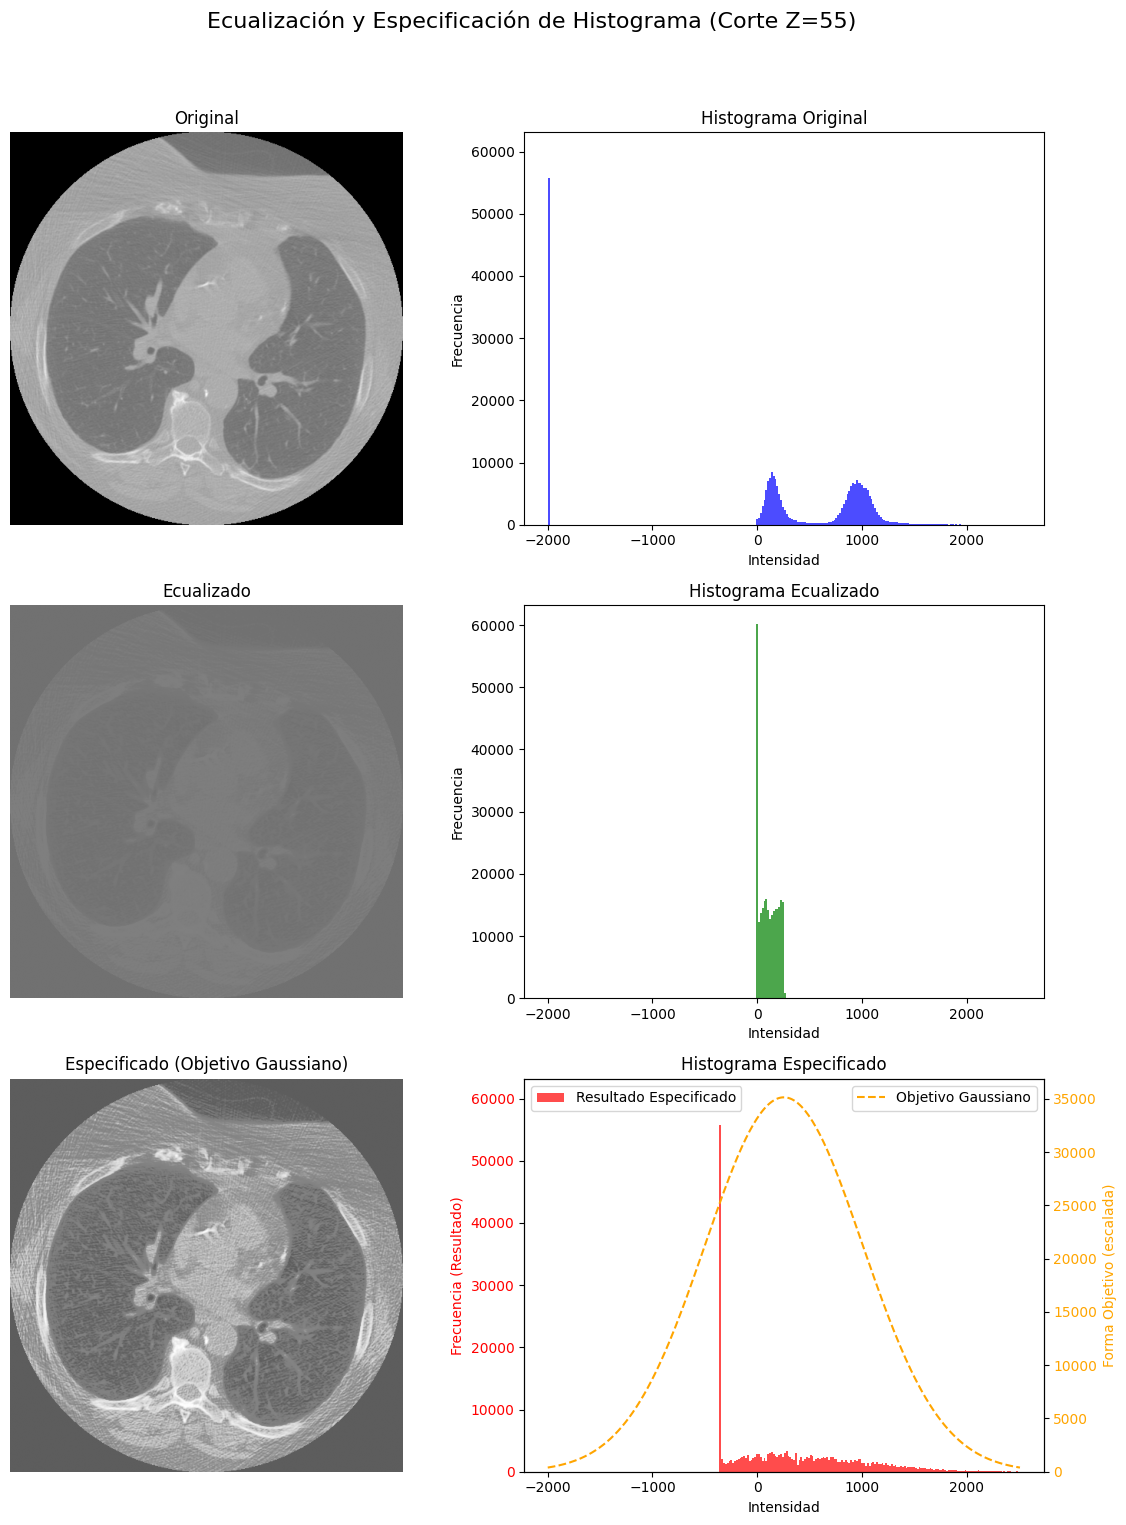

In [10]:
# Reutilizamos 'volume_3d' y las variables de intensidad 
if 'volume_3d' not in locals() or 'depth' not in locals():
     print("Falta 'volume_3d'. Ejecuta las celdas previas.")
else:
    # Seleccionamos un corte para trabajar 
    idx_corte_hist = depth // 2
    corte_original_hist = volume_3d[idx_corte_hist, :, :].copy() # Trabajamos con una copia

    # Determinamos el tipo de dato y el rango para los histogramas
    dtype_imagen = corte_original_hist.dtype
    if dtype_imagen.kind in 'iu': 
        min_img, max_img = int(corte_original_hist.min()), int(corte_original_hist.max())
        niveles_gris = max_img - min_img + 1
        rango_hist = (min_img, max_img + 1) 
        print(f"Imagen tipo entero. Rango: [{min_img}, {max_img}]. Niveles: {niveles_gris}")
    else: 
        min_img, max_img = float(corte_original_hist.min()), float(corte_original_hist.max())

        niveles_gris = 256
        rango_hist = (min_img, max_img)

    # Implementación Manual Ecualización
        def ecualizar_histograma(imagen, niveles, rango):
            """Ecualiza el histograma de una imagen."""
            # 1. Calcular el histograma
            hist, bordes_bin = np.histogram(imagen.ravel(), bins=niveles, range=rango)
            
            # 2. Calcular la Función de Distribución Acumulada (CDF)
            cdf = hist.cumsum() 
            
            # 3. Normalizar la CDF para usarla como mapeo
            cdf_mascara = np.ma.masked_equal(cdf, 0) # Ignorar ceros
            #    T(r) = (L-1) * CDF(r) / total_pixels
            #    cdf.max() es el total de píxeles
            if cdf.max() == 0: return imagen # Si no hay pixeles, devolver original
            
            cdf_mapeo = (cdf_mascara - cdf_mascara.min()) * (niveles - 1) / (cdf_mascara.max() - cdf_mascara.min())
            cdf_final = np.ma.filled(cdf_mapeo, 0).astype(imagen.dtype if imagen.dtype.kind in 'iu' else 'float')
            
            # 4. Aplicar el mapeo a la imagen original
            imagen_ecualizada = np.zeros_like(imagen)
            if imagen.dtype.kind in 'iu':
                min_val = int(rango[0])
                # Asegurarnos que los índices no se pasen de la LUT
                indices = np.clip(imagen.ravel() - min_val, 0, niveles - 1)
                imagen_ecualizada_flat = cdf_final[indices]
                imagen_ecualizada = imagen_ecualizada_flat.reshape(imagen.shape)
            else: # Float - Usar interpolación es más robusto
                valores_originales = bordes_bin[:-1] + (bordes_bin[1]-bordes_bin[0])/2 # Centros de bin approx
                imagen_ecualizada_flat = np.interp(imagen.ravel(), valores_originales, cdf_final)
                imagen_ecualizada = imagen_ecualizada_flat.reshape(imagen.shape).astype(imagen.dtype)

            return imagen_ecualizada

    # b) Implementación Manual Especificación 
    def especificar_histograma(imagen, pdf_objetivo, niveles, rango):
        """Especifica el histograma de 'imagen' para que se parezca a 'pdf_objetivo'."""
        
        # 1. Calcular CDF de la imagen original (T(r)) - Normalizada a [0, 1]
        hist_imagen, bordes_bin_img = np.histogram(imagen.ravel(), bins=niveles, range=rango)
        cdf_imagen = hist_imagen.cumsum()
        if cdf_imagen.max() == 0: return imagen
        cdf_imagen_norm = cdf_imagen / cdf_imagen.max() # T(r)

        # 2. Calcular CDF del histograma objetivo (G(z)) - Normalizada a [0, 1]
        if len(pdf_objetivo) != niveles:
             print(f"Error: PDF objetivo tiene {len(pdf_objetivo)} elementos, se esperaban {niveles}.")
             pdf_objetivo = np.interp(np.linspace(0, 1, niveles), np.linspace(0, 1, len(pdf_objetivo)), pdf_objetivo)

        pdf_objetivo_norm = pdf_objetivo / pdf_objetivo.sum() if pdf_objetivo.sum() > 0 else pdf_objetivo
        cdf_objetivo_norm = pdf_objetivo_norm.cumsum() # G(z)

        # 3. Encontrar el mapeo inverso: s = G^-1(T(r))
        mapeo_especif = np.zeros(niveles, dtype=np.int_)
        for idx_r in range(niveles):
            t_r = cdf_imagen_norm[idx_r]
            idx_z = np.argmin(np.abs(cdf_objetivo_norm - t_r))
            mapeo_especif[idx_r] = idx_z

        # 4. Aplicar el mapeo a la imagen original
        imagen_especificada = np.zeros_like(imagen)
        if imagen.dtype.kind in 'iu':
            min_val = int(rango[0])
            # Mapeamos usando la LUT 'mapeo_especif'
            indices = np.clip(imagen.ravel() - min_val, 0, niveles - 1)
            imagen_especificada_flat = mapeo_especif[indices] + min_val
            imagen_especificada = imagen_especificada_flat.reshape(imagen.shape).astype(imagen.dtype)
        else: 
             valores_originales = bordes_bin_img[:-1] + (bordes_bin_img[1]-bordes_bin_img[0])/2
             valores_mapeados_indices = np.interp(imagen.ravel(), valores_originales, mapeo_especif)
             valores_mapeados_reales = np.interp(valores_mapeados_indices, np.arange(niveles), valores_originales)
             imagen_especificada = valores_mapeados_reales.reshape(imagen.shape).astype(imagen.dtype)
             
        return imagen_especificada

    
    # a) Aplicar Ecualización
    corte_ecualizado = ecualizar_histograma(corte_original_hist, niveles_gris, rango_hist)

    # b) Definir PDF objetivo (Gaussiano) y aplicar Especificación
    media_objetivo = (max_img + min_img) / 2
    std_dev_objetivo = (max_img - min_img) / 6 # Desviación estándar 
    niveles_x = np.linspace(min_img, max_img, niveles_gris) # Eje X para la Gaussiana
    pdf_gaussiano = np.exp(-((niveles_x - media_objetivo)**2) / (2 * std_dev_objetivo**2))
    
    corte_especificado = especificar_histograma(corte_original_hist, pdf_gaussiano, niveles_gris, rango_hist)

    # c) Mostrar resultados
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    fig.suptitle(f'Ecualización y Especificación de Histograma (Corte Z={idx_corte_hist})', fontsize=16)

    # Fila 1: Original
    axes[0, 0].imshow(corte_original_hist, cmap='gray', vmin=min_img, vmax=max_img)
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')
    axes[0, 1].hist(corte_original_hist.ravel(), bins=niveles_gris, range=rango_hist, color='blue', alpha=0.7)
    axes[0, 1].set_title('Histograma Original')
    axes[0, 1].set_xlabel('Intensidad')
    axes[0, 1].set_ylabel('Frecuencia')

    # Fila 2: Ecualizado
    axes[1, 0].imshow(corte_ecualizado, cmap='gray', vmin=min_img, vmax=max_img)
    axes[1, 0].set_title('Ecualizado')
    axes[1, 0].axis('off')
    axes[1, 1].hist(corte_ecualizado.ravel(), bins=niveles_gris, range=rango_hist, color='green', alpha=0.7)
    axes[1, 1].set_title('Histograma Ecualizado')
    axes[1, 1].set_xlabel('Intensidad')
    axes[1, 1].set_ylabel('Frecuencia')

    # Fila 3: Especificado
    axes[2, 0].imshow(corte_especificado, cmap='gray', vmin=min_img, vmax=max_img)
    axes[2, 0].set_title('Especificado (Objetivo Gaussiano)')
    axes[2, 0].axis('off')
    ax_hist_spec = axes[2, 1]
    ax_hist_spec.hist(corte_especificado.ravel(), bins=niveles_gris, range=rango_hist, color='red', alpha=0.7, label='Resultado Especificado')
    ax_hist_spec.set_title('Histograma Especificado')
    ax_hist_spec.set_xlabel('Intensidad')
    ax_hist_spec.set_ylabel('Frecuencia (Resultado)', color='red')
    ax_hist_spec.tick_params(axis='y', labelcolor='red')


    ax_hist_target = ax_hist_spec.twinx()
    pdf_gaussiano_scaled = pdf_gaussiano * (ax_hist_spec.get_ylim()[1] / pdf_gaussiano.max() * 0.6) # Escalarla para que se vea bien
    ax_hist_target.plot(niveles_x, pdf_gaussiano_scaled, color='orange', linestyle='--', label=f'Objetivo Gaussiano')
    ax_hist_target.set_ylabel('Forma Objetivo (escalada)', color='orange')
    ax_hist_target.tick_params(axis='y', labelcolor='orange')
    ax_hist_target.set_ylim(bottom=0)
    ax_hist_spec.legend(loc='upper left')
    ax_hist_target.legend(loc='upper right')


    y_max_hist = max(axes[0,1].get_ylim()[1], axes[1,1].get_ylim()[1], axes[2,1].get_ylim()[1])
    axes[0,1].set_ylim(0, y_max_hist)
    axes[1,1].set_ylim(0, y_max_hist)
    axes[2,1].set_ylim(0, y_max_hist)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

**1. Ecualización de Histograma:**

* **Qué hace:** Intenta que todos los niveles de gris aparezcan con la misma frecuencia (histograma plano), usualmente para aumentar el contraste global.
* **Resultado en tu imagen:**
    * **Imagen "Ecualizado":** Se ve mucho más brillante y con un contraste muy alto, posiblemente excesivo y poco natural para la TC.
    * **Histograma "Ecualizado":** Las intensidades se han distribuido más ampliamente y desplazado hacia valores más altos, aunque no es perfectamente plano.

**2. Especificación de Histograma (Objetivo Gaussiano):**

* **Qué hace:** Modifica la imagen para que su histograma se parezca a una forma predefinida (aquí, una campana de Gauss).
* **Resultado en tu imagen:**
    * **Imagen "Especificado":** El contraste es más moderado que en la ecualizada y diferente de la original. El brillo y contraste siguen la forma gaussiana.
    * **Histograma "Especificado":** El histograma de la imagen resultante (rojo) intenta imitar la forma de la curva gaussiana objetivo (amarilla).

**En resumen:**

* La **ecualización** produjo un cambio de contraste fuerte y un brillo general alto, que podría no ser ideal.
* La **especificación** (con objetivo gaussiano) dio un control más fino, ajustando la imagen a un perfil de contraste específico, resultando en una apariencia diferente, potencialmente más equilibrada que la ecualizada.

## 3.2.1 Filtrado Espacial

El filtrado espacial es una técnica fundamental en el procesamiento de imágenes que opera directamente sobre los píxeles de una imagen. Consiste en aplicar una operación (generalmente una convolución con un kernel o máscara) a la vecindad de cada píxel para obtener un nuevo valor para ese píxel en la imagen resultante.

Los objetivos comunes del filtrado espacial incluyen:
* **Reducción de ruido:** Suavizar la imagen para atenuar variaciones aleatorias de intensidad (ej. filtros promedio, Gaussiano, mediana).
* **Realce de bordes:** Detectar y resaltar cambios bruscos de intensidad, que usualmente corresponden a bordes de objetos (ej. filtros Sobel, Laplaciano).

En esta sección, implementaremos manualmente (sin usar librerías específicas de PDI como `scipy.ndimage` o `opencv` para la convolución o filtros predefinidos) los siguientes filtros:
1.  **Filtro Promedio (Average Filter):** Un filtro lineal simple que reemplaza cada píxel por el promedio de sus vecinos (incluyéndose a sí mismo). Usaremos un kernel de 3x3.
2.  **Filtro Gaussiano:** Un filtro lineal que usa una máscara cuyos coeficientes siguen una distribución Gaussiana. Produce un suavizado más suave que el filtro promedio, preservando mejor los bordes. Implementaremos una versión simple o usaremos un kernel 3x3 precalculado.
3.  **Filtro de Mediana:** Un filtro no lineal que reemplaza cada píxel por la mediana de los valores en su vecindad. Es muy efectivo para eliminar ruido impulsivo (sal y pimienta) preservando relativamente bien los bordes. Se implementará recorriendo vecindades y calculando la mediana.
4.  **Filtro Sobel:** Utilizado para la detección de bordes. Usa dos kernels (uno para gradiente horizontal $G_x$ y otro para vertical $G_y$) para aproximar las derivadas parciales. La magnitud del gradiente ($G = \sqrt{G_x^2 + G_y^2}$) indica la presencia de un borde.

Aplicaremos estos filtros a una imagen de ejemplo `data2` y visualizaremos los resultados.

Finalmente, calcularemos la Relación Señal-Ruido (SNR) en una región homogénea de la imagen original para caracterizar el nivel de ruido presente, usando la fórmula $SNR = \frac{\mu_{sig}}{\sigma_{sig}}$, donde $\mu_{sig}$ y $\sigma_{sig}$ son la media y desviación estándar de la región seleccionada.


Aplicando filtros al corte Z=55 de data_2...
Filtros manuales aplicados.
Comparando resultado Gaussiano con scipy.ndimage.convolve...
 -> Diferencia Máxima Absoluta: 9.0949e-13
 -> Diferencia Media Absoluta: 1.9017e-13


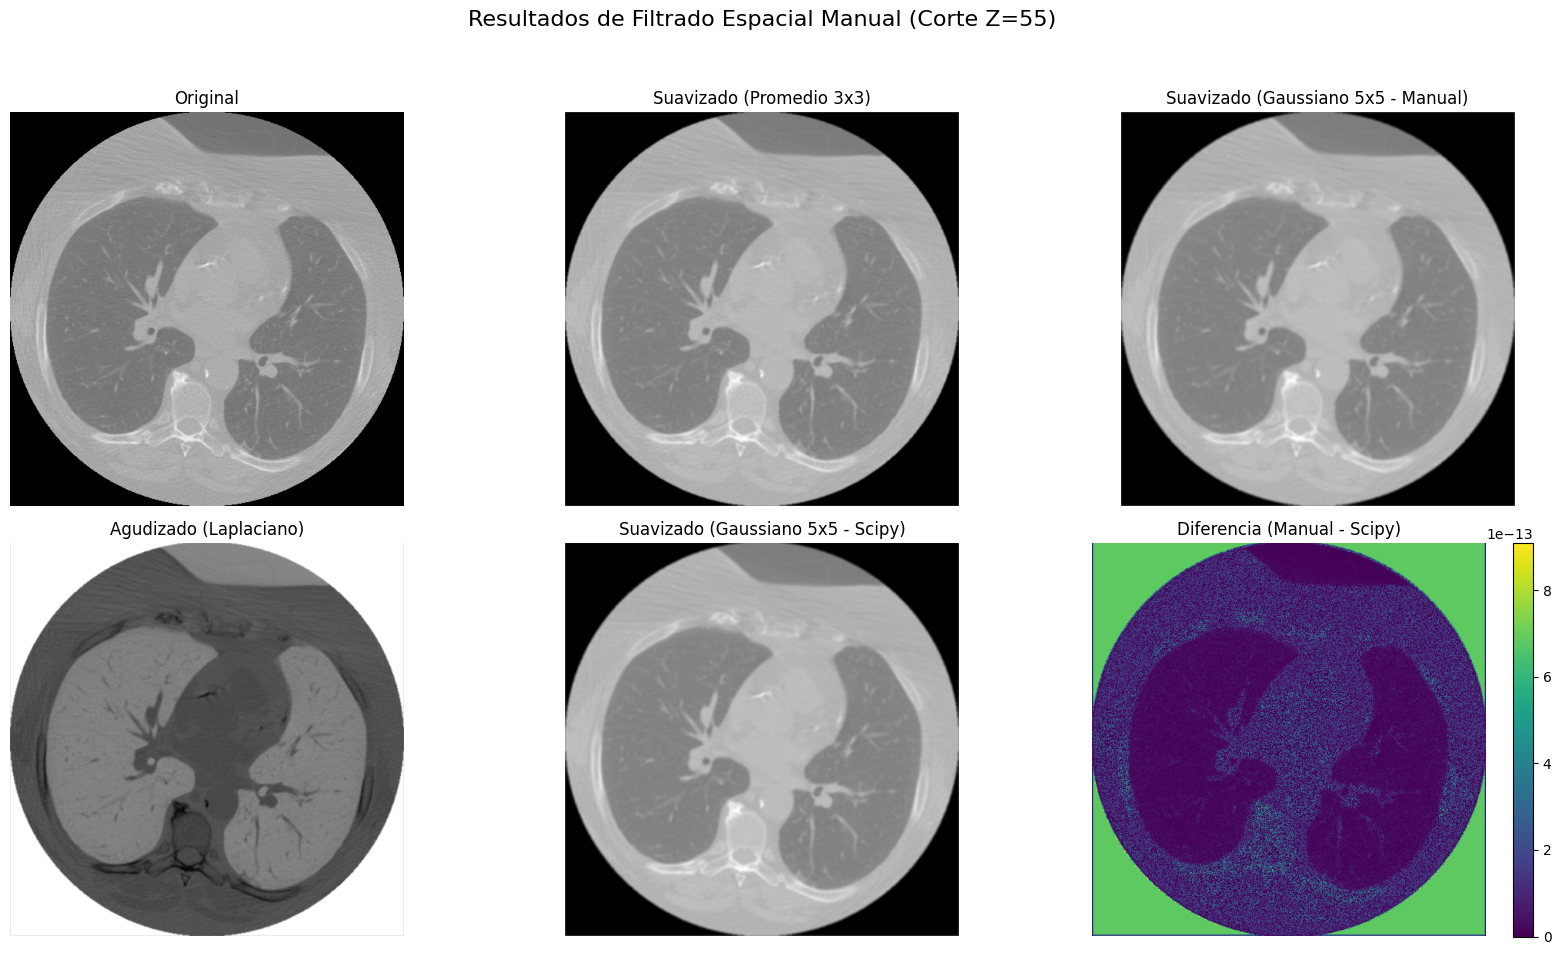

In [11]:
def mi_convolve2d(imagen, kernel):
    """
    Calcula la convolución 2D entre una imagen y un kernel (filtro).
    Implementación manual paso a paso.
    Asume que el kernel tiene dimensiones impares (ej. 3x3, 5x5).
    """
    # Averiguamos las dimensiones de la imagen y el kernel
    alto_k, ancho_k = kernel.shape
    alto_img, ancho_img = imagen.shape

    pad_alto = (alto_k - 1) // 2
    pad_ancho = (ancho_k - 1) // 2
    
    imagen_padded = np.pad(imagen, ((pad_alto, pad_alto), (pad_ancho, pad_ancho)), 
                           mode='constant', constant_values=0) # Rellenamos con ceros

    # para guardar el resultado
    resultado = np.zeros_like(imagen)

    # horizontal y verticalmente antes de aplicarlo.
    kernel_volteado = np.flipud(np.fliplr(kernel))

    for y in range(alto_img):
        for x in range(ancho_img):

            region = imagen_padded[y : y + alto_k, x : x + ancho_k]


            resultado[y, x] = np.sum(region * kernel_volteado)

    return resultado

# Función para crear un Kernel Gaussiano 
def crear_kernel_gaussiano(tamano, sigma=1.0):
    """Genera un kernel (filtro) Gaussiano 2D."""

    if tamano % 2 == 0:

        print(f"Advertencia: Tamaño {tamano} es par, se usará {tamano+1}")
        tamano += 1 # Lo hacemos impar
    
    centro = tamano // 2
    kernel = np.zeros((tamano, tamano))
    
    # Aplicamos la fórmula de la Gaussiana 2D para cada celda del kernel
    for i in range(tamano):
        for j in range(tamano):
            dist_cuadrado = (i - centro)**2 + (j - centro)**2
            kernel[i, j] = np.exp(-dist_cuadrado / (2 * sigma**2))
            
    # Normalizamos el kernel para que la suma de todos sus elementos sea 1.

    suma_kernel = kernel.sum()
    if suma_kernel != 0:
        kernel = kernel / suma_kernel
        
    return kernel

# Definición de los Kernels a usar 

# 1. Suavizado: Filtro de Promedio 3x3 (todos los vecinos pesan igual)
kernel_promedio_3x3 = np.ones((3, 3), dtype=np.float64) / 9.0

# 2. Suavizado: Filtro Gaussiano 5x5 (vecinos cercanos pesan más)
kernel_gaussiano_5x5 = crear_kernel_gaussiano(tamano=5, sigma=1.5) 

# 3. Agudizado: Filtro Laplaciano (detecta cambios bruscos - bordes)
kernel_laplaciano = np.array([[1,  1,  1],
                              [1, 8,  1],
                              [1,  1,  1]], dtype=np.float64)

# Aplicamos los filtros a un corte del CT 

if 'volume_3d' not in locals():
     print("Error: 'volume_3d' no encontrado. Ejecuta las celdas anteriores.")
else:

    idx_corte_filtrar = depth // 2 
    imagen_original_ct = volume_3d[idx_corte_filtrar, :, :].astype(np.float64) 
    print(f"\nAplicando filtros al corte Z={idx_corte_filtrar} de data_2...")

    # Aplicamos nuestros filtros usando nuestra convolución manual
    img_suavizada_prom = mi_convolve2d(imagen_original_ct, kernel_promedio_3x3)
    img_suavizada_gauss = mi_convolve2d(imagen_original_ct, kernel_gaussiano_5x5)
    resultado_laplaciano = mi_convolve2d(imagen_original_ct, kernel_laplaciano)
    
    # Calculamos la imagen agudizada restando el resultado del Laplaciano
    img_agudizada_lap = imagen_original_ct - resultado_laplaciano
    
    print("Filtros manuales aplicados.")

    print("Comparando resultado Gaussiano con scipy.ndimage.convolve...")
    img_suavizada_gauss_scipy = scipy_convolve(imagen_original_ct, kernel_gaussiano_5x5, 
                                             mode='constant', cval=0.0)
    
    # Calculamos la diferencia absoluta entre nuestro resultado y el de Scipy
    diferencia_gauss = np.abs(img_suavizada_gauss - img_suavizada_gauss_scipy)
    print(f" -> Diferencia Máxima Absoluta: {np.max(diferencia_gauss):.4e}") # Notación científica
    print(f" -> Diferencia Media Absoluta: {np.mean(diferencia_gauss):.4e}")

    fig, axes = plt.subplots(2, 3, figsize=(17, 10)) 
    fig.suptitle(f'Resultados de Filtrado Espacial Manual (Corte Z={idx_corte_filtrar})', fontsize=16)

    # Fila 1
    axes[0, 0].imshow(imagen_original_ct, cmap='gray')
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(img_suavizada_prom, cmap='gray')
    axes[0, 1].set_title('Suavizado (Promedio 3x3)')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(img_suavizada_gauss, cmap='gray')
    axes[0, 2].set_title('Suavizado (Gaussiano 5x5 - Manual)')
    axes[0, 2].axis('off')

    # Fila 2
    axes[1, 0].imshow(img_agudizada_lap, cmap='gray')
    axes[1, 0].set_title('Agudizado (Laplaciano)')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(img_suavizada_gauss_scipy, cmap='gray')
    axes[1, 1].set_title('Suavizado (Gaussiano 5x5 - Scipy)')
    axes[1, 1].axis('off')

    # Mostramos la diferencia entre manual y scipy
    im_diff = axes[1, 2].imshow(diferencia_gauss, cmap='viridis') # 'hot' o 'viridis' para diferencias
    axes[1, 2].set_title('Diferencia (Manual - Scipy)')
    axes[1, 2].axis('off')
    fig.colorbar(im_diff, ax=axes[1, 2]) # Barra de color para la diferencia

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

## 3.2.2

Imagen xray.dcm cargada. Dimensiones: (1024, 1024)
Paso 1: Imagen suavizada.
Paso 2: Máscara de detalles calculada.
Paso 3: Combinación realizada con k=2 (High-Boost).


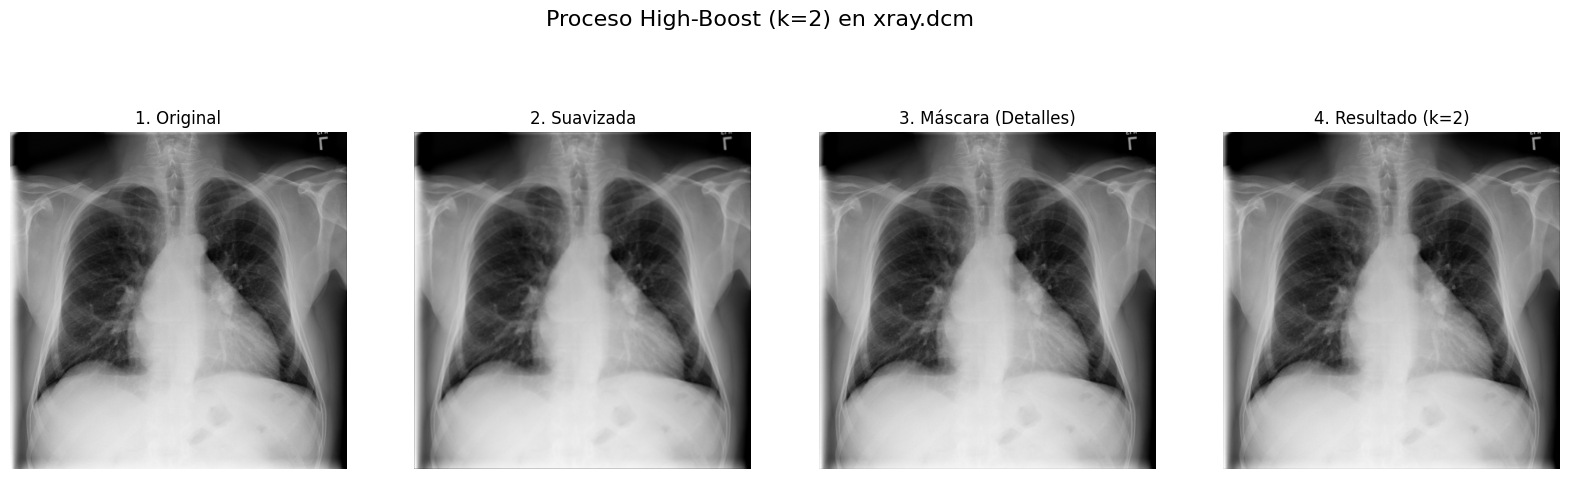

In [12]:

# Cargamos la imagen de rayos X
ds_xray = pydicom.dcmread(xray_filepath)
imagen_xray = ds_xray.pixel_array.astype(np.float64) # Convertir a float
print(f"Imagen {os.path.basename(xray_filepath)} cargada. Dimensiones: {imagen_xray.shape}")

# 1. Suavizar la imagen original. 
kernel_suavizado_xray = crear_kernel_gaussiano(tamano=5, sigma=2.0) 
imagen_xray_suavizada = mi_convolve2d(imagen_xray, kernel_suavizado_xray)
print("Paso 1: Imagen suavizada.")

# 2. Calcular la máscara (detalles) = Original - Suavizada
mascara_detalles = mi_convolve2d(imagen_xray, kernel_laplaciano)
print("Paso 2: Máscara de detalles calculada.")

# 3. Combinar: Imagen Realzada = Original + k * Máscara
#    k=1 es Unsharp Masking estándar.
#    k>1 se llama High-Boost filtering (realza aún más).
k = 2
imagen_xray_realzada = imagen_xray + k * mascara_detalles
print(f"Paso 3: Combinación realizada con k={k} (High-Boost).")

fig, axes = plt.subplots(1, 4, figsize=(20, 6)) 
fig.suptitle(f'Proceso High-Boost (k={k}) en {os.path.basename(xray_filepath)}', fontsize=16)

axes[0].imshow(imagen_xray, cmap='gray')
axes[0].set_title('1. Original')
axes[0].axis('off')

axes[1].imshow(imagen_xray_suavizada, cmap='gray')
axes[1].set_title('2. Suavizada')
axes[1].axis('off')


axes[2].imshow(mascara_detalles, cmap='gray') 
axes[2].set_title('3. Máscara (Detalles)')
axes[2].axis('off')

axes[3].imshow(imagen_xray_realzada, cmap='gray')
axes[3].set_title(f'4. Resultado (k={k})')
axes[3].axis('off')

plt.show()


La aplicación combinada de filtros de suavizado y agudizado, según la sección 3.7 (página 169) del documento, busca realzar, mejorando detalles finos y bordes importantes mientras se controla el ruido. La pertinencia de los pasos es:

1.  **Cálculo del Laplaciano:** Se usa para resaltar detalles finos en la radiografía (texturas óseas, fisuras sutiles). Su desventaja es que también amplifica el ruido.
2.  **Cálculo del Gradiente (ej. Sobel):** Identifica los bordes más prominentes (contornos de huesos) con una menor amplificación de ruido en comparación con el Laplaciano.
3.  **Suavizado del Gradiente:** Reduce el ruido en la imagen del gradiente. Esto crea una "máscara" más limpia que solo representa las regiones de bordes significativos.
4.  **Producto del Laplaciano y Gradiente Suavizado:** Este paso es crucial. La máscara del gradiente suavizado modula la imagen Laplaciana. Así, el agudizado del Laplaciano se aplica con más fuerza en los bordes importantes (detectados por el gradiente) y se atenúa en regiones más planas (donde el Laplaciano principalmente realzaría ruido). Se combinan las fortalezas de ambos filtros.
5.  **Suma del resultado a la imagen original:** Integra las mejoras (detalles agudizados selectivamente) de nuevo en la imagen original, produciendo una imagen general más nítida.
6.  **Transformación de Intensidad (ej. Ley de Potencia):** Mejora el contraste general y expande el rango dinámico de la imagen agudizada. Esto es vital en radiografías para hacer visibles detalles sutiles en áreas que podrían ser demasiado oscuras o claras.

En resumen, este proceso permite un agudizado inteligente: se realzan los detalles importantes (mediante el Laplaciano en las zonas indicadas por el gradiente) y se definen mejor los bordes principales, todo mientras se intenta minimizar la amplificación de ruido y se mejora el contraste final para una mejor visualización diagnóstica de la `xray.dcm`.

## 3.2.3


Calculando SNR para la ROI: Y=[180:230], X=[270:320]

--- Resultados SNR ---
ROI Original:
  - Media (μ):          1049.2220
  - Desv. Estándar (σ): 68.0860
  - SNR (μ/σ):          15.4102

ROI Suavizada (Gaussiana):
  - Media (μ):          1049.6070
  - Desv. Estándar (σ): 42.9368
  - SNR (μ/σ):          24.4454


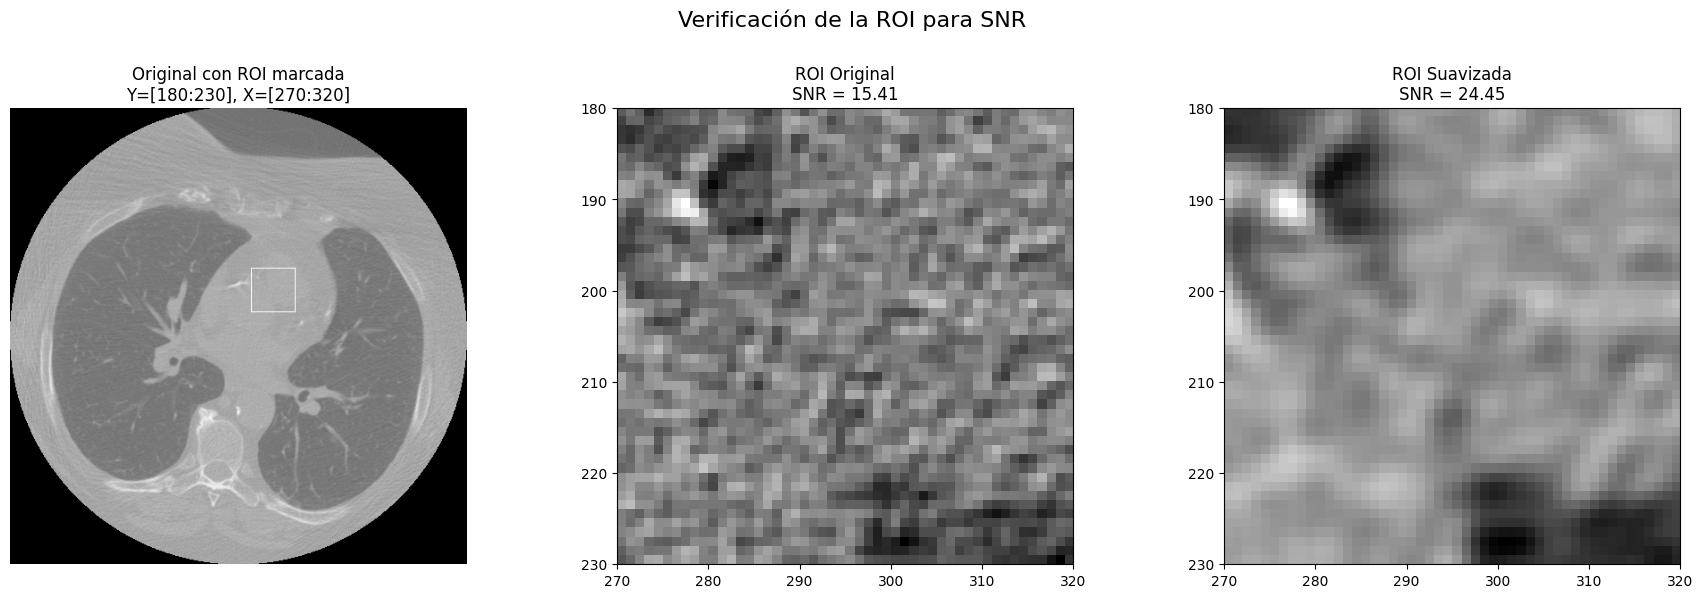

In [13]:
roi_y1, roi_y2 = 180, 230
roi_x1, roi_x2 = 270, 320

print(f"\nCalculando SNR para la ROI: Y=[{roi_y1}:{roi_y2}], X=[{roi_x1}:{roi_x2}]")

alto_img_roi, ancho_img_roi = imagen_original_ct.shape
if not (0 <= roi_y1 < roi_y2 <= alto_img_roi and 0 <= roi_x1 < roi_x2 <= ancho_img_roi):
    print("Las coordenadas de la ROI no son válidas o están fuera de la imagen.")
else:

    roi_original = imagen_original_ct[roi_y1:roi_y2, roi_x1:roi_x2]
    roi_suavizada = img_suavizada_gauss[roi_y1:roi_y2, roi_x1:roi_x2] 

    def calcular_snr(region):
        """Calcula SNR = media / desviación estándar."""
        media = np.mean(region)
        desv_std = np.std(region)

        if desv_std == 0:

            return np.inf if media != 0 else 0
        return media / desv_std

    # Calculamos SNR para ambas ROIs
    snr_antes = calcular_snr(roi_original)
    snr_despues = calcular_snr(roi_suavizada)

    print(f"\n--- Resultados SNR ---")
    print(f"ROI Original:")
    print(f"  - Media (μ):          {np.mean(roi_original):.4f}")
    print(f"  - Desv. Estándar (σ): {np.std(roi_original):.4f}")
    print(f"  - SNR (μ/σ):          {snr_antes:.4f}")
    
    print(f"\nROI Suavizada (Gaussiana):")
    print(f"  - Media (μ):          {np.mean(roi_suavizada):.4f}")
    print(f"  - Desv. Estándar (σ): {np.std(roi_suavizada):.4f}")
    print(f"  - SNR (μ/σ):          {snr_despues:.4f}")



    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Verificación de la ROI para SNR', fontsize=16)
    
    # Marcamos la ROI en la imagen original
    img_con_roi = imagen_original_ct.copy()

    color_rect = img_con_roi.max() 
    img_con_roi[roi_y1:roi_y2, roi_x1] = color_rect
    img_con_roi[roi_y1:roi_y2, roi_x2-1] = color_rect
    img_con_roi[roi_y1, roi_x1:roi_x2] = color_rect
    img_con_roi[roi_y2-1, roi_x1:roi_x2] = color_rect

    axes[0].imshow(img_con_roi, cmap='gray')
    axes[0].set_title(f'Original con ROI marcada\nY=[{roi_y1}:{roi_y2}], X=[{roi_x1}:{roi_x2}]')
    axes[0].axis('off')

    # Mostramos la ROI original ampliada
    axes[1].imshow(roi_original, cmap='gray', extent=[roi_x1, roi_x2, roi_y2, roi_y1]) # extent invierte Y
    axes[1].set_title(f'ROI Original\nSNR = {snr_antes:.2f}')
    
    # Mostramos la ROI suavizada ampliada
    axes[2].imshow(roi_suavizada, cmap='gray', extent=[roi_x1, roi_x2, roi_y2, roi_y1])
    axes[2].set_title(f'ROI Suavizada\nSNR = {snr_despues:.2f}')

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

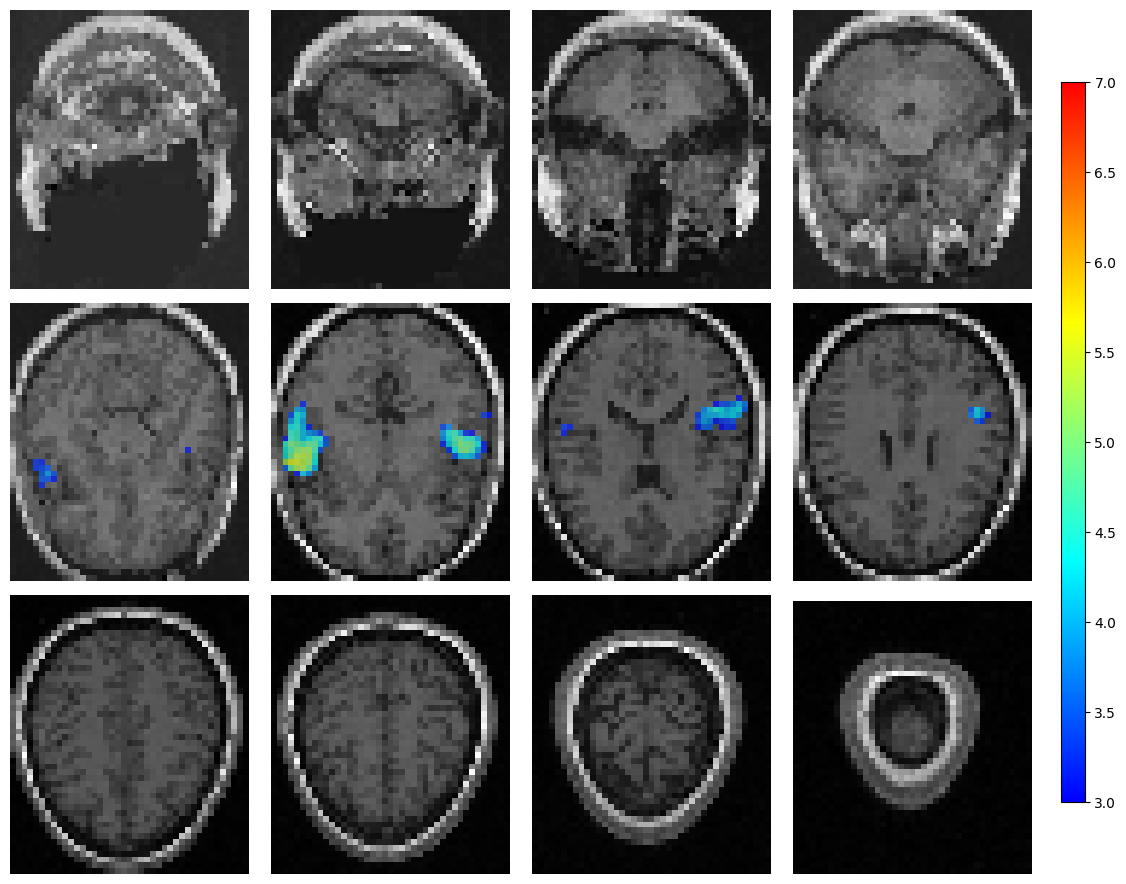

In [14]:
# Cargar los datos
anat = nib.load('./Tarea_1/datos/anat.nii').get_fdata()
zmap_voice = nib.load('./Tarea_1/datos/zmap_voice.nii').get_fdata()
zmap_nonvoice = nib.load('./Tarea_1/datos/zmap_nonvoice.nii').get_fdata()

# Combinar las activaciones (tomar el máximo entre voice y nonvoice)
combined_zmap = np.maximum(zmap_voice, zmap_nonvoice)

# Crear un mapa de colores personalizado (azul-cian-amarillo-rojo)
colors = [(0, 0, 1), (0, 1, 1), (1, 1, 0), (1, 0, 0)]  # Azul, Cian, Amarillo, Rojo
cmap = mcolors.LinearSegmentedColormap.from_list('activation', colors)

# Selección de rebanadas axiales (12 rebanadas en total)
n_slices = 12
z_size = anat.shape[2]
slice_indices = np.linspace(0, z_size - 1, n_slices).astype(int)

# Crear figura con rejilla 3x4
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()

# Graficar cada rebanada
for i, ax in enumerate(axes):
    idx = slice_indices[i]
    # Rebanada anatómica (transponer para orientación correcta)
    anat_slice = anat[:, :, idx].T
    # Rebanada de activación (transponer para orientación correcta)
    zmap_slice = combined_zmap[:, :, idx].T
    
    # Mostrar imagen anatómica en escala de grises
    ax.imshow(anat_slice, cmap='gray')
    
    # Overlay de la activación (máscara para valores >=3)
    masked_zmap = np.ma.masked_less(zmap_slice, 0.03)
    ax.imshow(masked_zmap, cmap=cmap, alpha=0.7, vmin=0.03, vmax=0.07)
    
    # Ocultar ejes
    ax.axis('off')

# Ajustar distribución de la figura
plt.subplots_adjust(left=0.02, right=0.88, bottom=0.02, top=0.98, wspace=0.05, hspace=0.05)

# Agregar barra de colores
cax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=3, vmax=7))
sm.set_array([])
fig.colorbar(sm, cax=cax)

plt.show()

no me funciona :(